# Naive Bayes 

Vi antar att alla parametrar är oberoende och att alla parametrar bidra lika till utfallet. 


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

data = pd.read_csv("../data/spam.csv", encoding="latin-1")

data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [56]:
np.sum(data[data.columns[2:].tolist()].notna())

c:\Users\User\Documents\Programering\Plugg AI\AI-plugg-filer-Hannes-Fredriksson\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Unnamed: 2    50
Unnamed: 3    12
Unnamed: 4     6
dtype: int64

In [57]:
data.loc[data["Unnamed: 2"].notna()].iloc[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN


In [58]:
data_no_NaN = data.dropna(axis=1)
data_no_NaN.columns = ["class", "content"]
data_no_NaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5572 non-null   object
 1   content  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


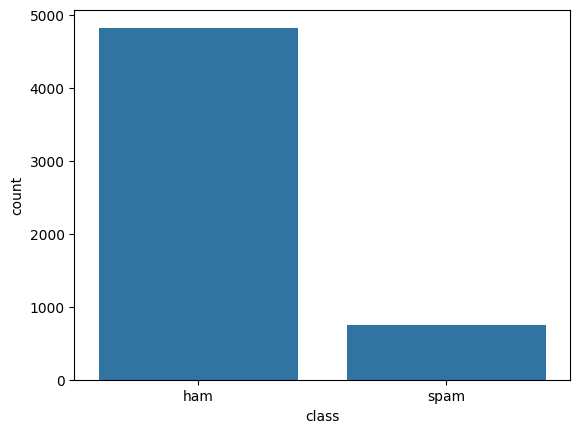

In [59]:
sns.countplot(data = data_no_NaN, x = "class");

In [60]:
data = pd.get_dummies(data_no_NaN, columns=["class"], drop_first=True)

X, y = data["content"], data["class_spam"]

X.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: content, dtype: object

### TF-IDF

Hur vi matar in text till tal, så vi kan jämnför det med andra. Alltså skriva om text till metriser. TF-IDF vector gör detta genom ge texten trärmer och jämnför något slags medel utifrån andra stycken text. 

$TF = \frac{Antalet gånger ordet förekommerr i dokumentet}{Totala antalet ord i dokumentet}$

$IDF = \frac{Totaöt antal dokumnet}{Antalet dokumnet som innehåller ordet}$

Där höga värden av TF och IDF vissar på att orden är vanligt förre kommande. Om låga värden förekommer dom mer sällan. Detta räknat i dokumnet och i vilka som har orden. 



In [61]:
tfidf = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf.fit_transform(X)

print(X_tfidf[1])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 8404)>
  Coords	Values
  (0, 5343)	0.27211951321382544
  (0, 4385)	0.4082988561907181
  (0, 4192)	0.5236458071582338
  (0, 8134)	0.4316010362639011
  (0, 5369)	0.5465881710238072


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape

((3733, 8404), (1839, 8404))

I detta fall så har vi en deimsion för varje ord, 8404 dimensioner. Detta är även vad vi ser som tokens också. 

<Axes: xlabel='class_spam', ylabel='count'>

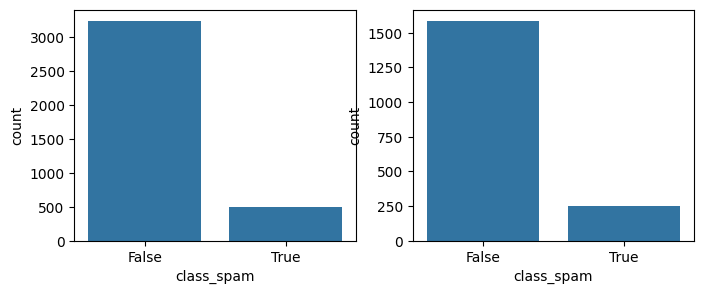

In [63]:
fig, ax = plt.subplots(1,2,dpi=100, figsize=(8,3))
sns.countplot(x=y_train, ax = ax[0])
sns.countplot(x=y_test, ax = ax[1])


---
## Naive Bayes

- family of probability classifiers based on Bayes theorem
- they have strong naive independent assumption between features 
- for text it means that the each word is assumed to be independent of other words (bag of words model)

For features $\vec{x} = (x_1,\ldots, x_n)$ and class $k$ the Bayes theorem gives: 
$$P(C_k|\vec{x}) \overbrace{=}^{Bayes} \frac{P(C_k)P(\vec{x}|C_k)}{P(\vec{x})} \overbrace{=}^{\text{conditional probability}} \frac{P(C_k, x_1, \ldots, x_n)}{P(\vec{x})}$$

Here we make an big assumption that all $X_n$ is mutually independent. 

Note first that $P(\vec{x})$ is the same value and we make an assumption that all features are mutually independent of each other. This assumption is naive as for words in a document, usually they are dependent on each other. 

$$P(C_k|x_1,\ldots, x_n) \propto P(C_k, x_1, \ldots, x_n) \propto P(C_k)P(x_1|C_k)P(x_2|C_k)\ldots P(x_n|C_k) \propto P(C_k)\prod_{i=1}^{n}P(x_i|C_k)$$

We look for the maximum likelyhood for finding the relativ frevkvensy for likeleyhood of ceritian class. 

By combining this model with a maximum a posteriori (MAP) decision rule we get a classifier for $\hat{y} = C_k$: 
$$\hat{y} = \arg \max_{k\in\{1,\ldots,K\}} P(C_k)\prod_{i=1}^{n}P(x_i|C_k)$$

Naive baye is an great classfier in certian instanses. Like when you do know the anwser. 


              precision    recall  f1-score   support

       False       1.00      0.96      0.98      1650
        True       0.75      1.00      0.86       189

    accuracy                           0.97      1839
   macro avg       0.88      0.98      0.92      1839
weighted avg       0.97      0.97      0.97      1839



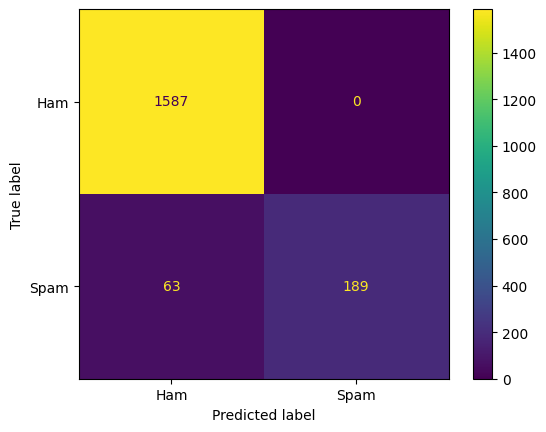

In [64]:
naive_bays = dict(
    multinomial = MultinomialNB(),
    benoulli = BernoulliNB(),
    complment = ComplementNB()
)

def eval_model (model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_pred, y_test))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"]).plot()

#precision = TP/ (TP+FP)
#recall = TP/(TP+FN)

eval_model(naive_bays["multinomial"])

              precision    recall  f1-score   support

       False       1.00      0.97      0.98      1629
        True       0.81      0.98      0.89       210

    accuracy                           0.97      1839
   macro avg       0.91      0.97      0.94      1839
weighted avg       0.98      0.97      0.97      1839



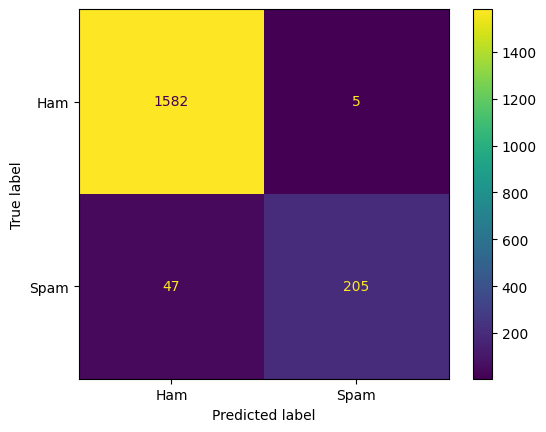

In [65]:
eval_model(naive_bays["benoulli"])

              precision    recall  f1-score   support

       False       0.92      0.99      0.96      1482
        True       0.94      0.66      0.78       357

    accuracy                           0.93      1839
   macro avg       0.93      0.83      0.87      1839
weighted avg       0.93      0.93      0.92      1839



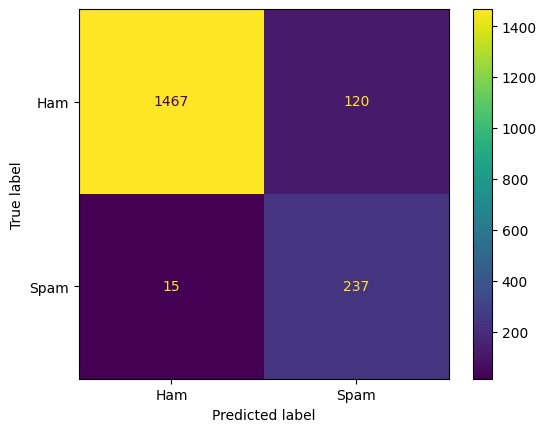

In [66]:
eval_model(naive_bays["complment"])

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1618
        True       0.85      0.97      0.91       221

    accuracy                           0.98      1839
   macro avg       0.92      0.97      0.95      1839
weighted avg       0.98      0.98      0.98      1839



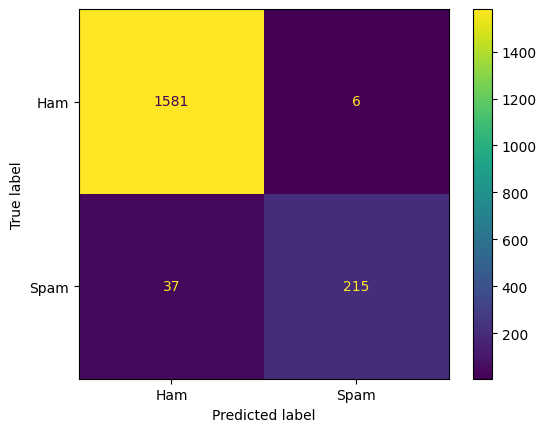

In [67]:
eval_model(LinearSVC())

              precision    recall  f1-score   support

       False       1.00      0.97      0.99      1628
        True       0.84      1.00      0.91       211

    accuracy                           0.98      1839
   macro avg       0.92      0.99      0.95      1839
weighted avg       0.98      0.98      0.98      1839



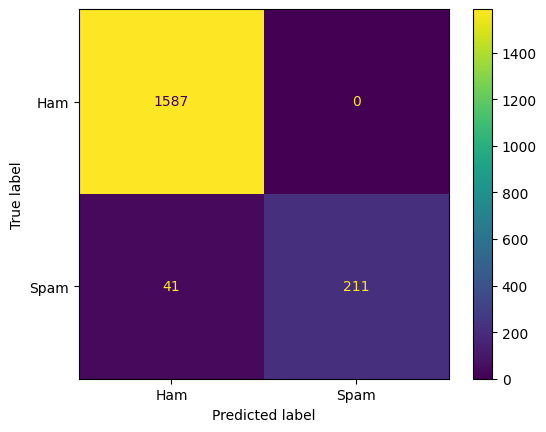

In [68]:
eval_model(RandomForestClassifier())

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1623
        True       0.86      1.00      0.92       216

    accuracy                           0.98      1839
   macro avg       0.93      0.99      0.96      1839
weighted avg       0.98      0.98      0.98      1839



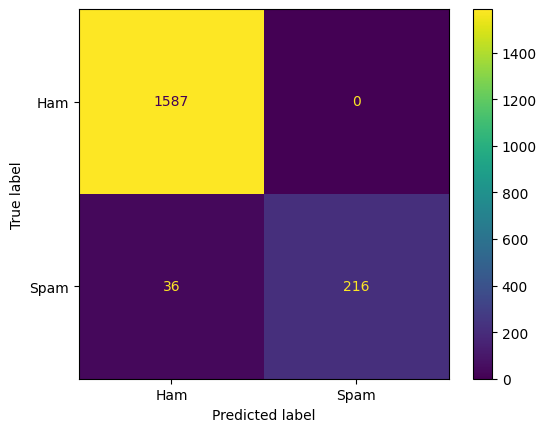

In [73]:
# Combning models and vote on the class

vote_clf = VotingClassifier([
    ("rf", RandomForestClassifier()),
    ("svc", LinearSVC()),
    ("naive_complement", ComplementNB()),
    ("naive_bernoulli", BernoulliNB()),
    ("naive_multinomial", MultinomialNB())],
    voting="hard",
    n_jobs=-1
)

eval_model(vote_clf)

In [74]:
pipe = Pipeline([("tfidf", TfidfVectorizer(stop_words="english")), ("vote", vote_clf)])

pipe.fit(X, y)
pipe.predict(["Come collect your $4.5 million in Bitcoin"])

array([False])

In [75]:
pipe.predict(["You won 10 000 dollar for free"])

array([ True])